✓ Imports successful
\n================================================================================
LOADING DATASETS
✓ Loaded linear: 50000 records
✓ Loaded linear_noisy: 50000 records
✓ Loaded quadratic: 50000 records
✓ Loaded cubic: 50000 records
✓ Loaded step: 50000 records
✓ Loaded clustered: 50000 records
✓ Loaded exponential: 50000 records
\n✓ Loaded 7 datasets
\n✓ RMI class defined
✓ Binary search baseline defined
\n================================================================================
EVALUATING RMI BASELINE
\n================================================================================
Testing on LINEAR dataset
\n  Configuration: RMI-Linear-50
\n  Building RMI with 50 stage-2 models...
  Training Stage 1 (root model)...
  Training Stage 2 (50 expert models)...
  ✓ RMI built in 145.01 ms
    RMI lookup: 789.649 μs
    Binary search: 15.479 μs
    Speedup: 0.02x
    Avg error: 126.9 positions
    Build time: 145.01 ms
\n  Configuration: RMI-Linear-100
\n  Buildi

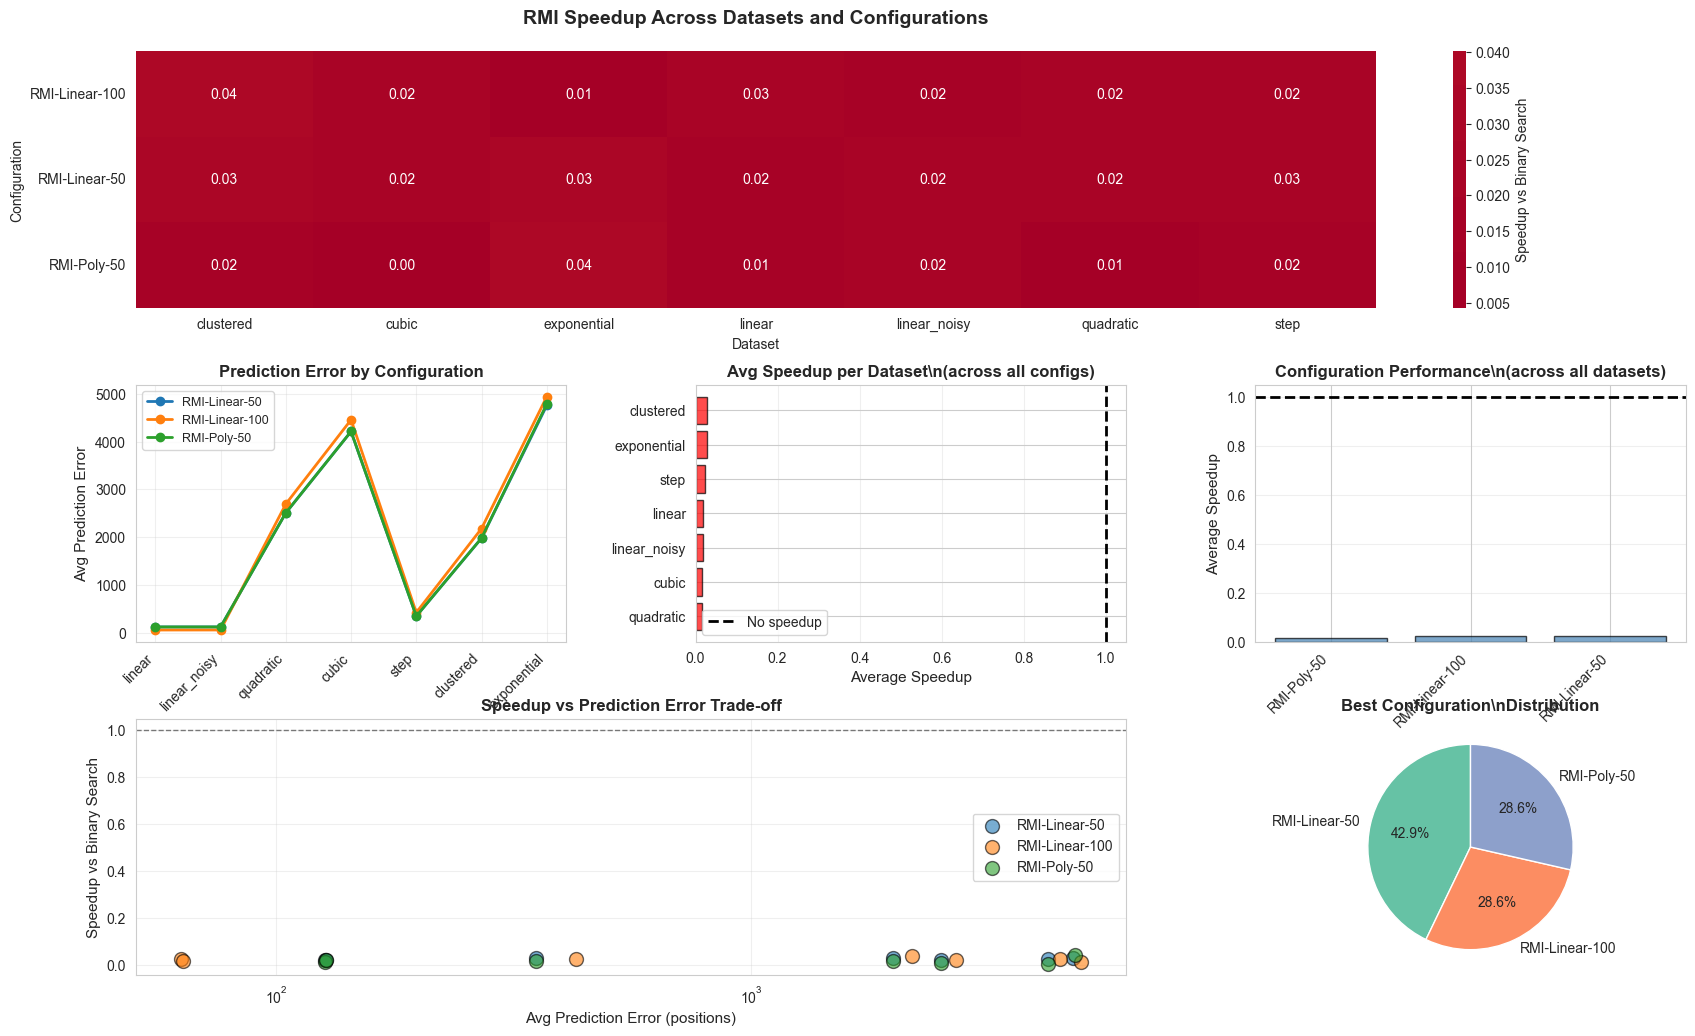

\n================================================================================
RMI PERFORMANCE SUMMARY
\n      Dataset         Config Speedup RMI (μs) Binary (μs) Avg Error Build (ms)
      linear  RMI-Linear-50   0.02x   789.65       15.48     126.9      145.0
      linear RMI-Linear-100   0.03x   911.86       23.16      63.1      162.4
      linear    RMI-Poly-50   0.01x   917.41       12.41     127.1      364.0
linear_noisy  RMI-Linear-50   0.02x   586.01       11.63     127.3      102.9
linear_noisy RMI-Linear-100   0.02x   808.99       12.27      63.6      170.6
linear_noisy    RMI-Poly-50   0.02x  1053.12       21.65     127.3      172.0
   quadratic  RMI-Linear-50   0.02x  1168.48       24.57    2510.8       73.6
   quadratic RMI-Linear-100   0.02x   363.12        7.42    2696.7      307.5
   quadratic    RMI-Poly-50   0.01x  1176.89        7.46    2510.7       72.3
       cubic  RMI-Linear-50   0.02x   322.02        7.48    4212.0      143.3
       cubic RMI-Linear-100   0.

In [1]:
# 03_rmi_baseline.ipynb
# Recursive Model Index (RMI) Baseline Implementation
# This is the REAL baseline for comparison - not simple binary search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import time
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)

print("✓ Imports successful")

# ==============================================================================
# PART 1: LOAD DATASETS
# ==============================================================================

print("\\n" + "="*80)
print("LOADING DATASETS")
print("="*80)

import os

datasets = {}
dataset_names = ['linear', 'linear_noisy', 'quadratic', 'cubic',
                 'step', 'clustered', 'exponential']

for name in dataset_names:
    filepath = f'datasets/{name}_50k.csv'
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        datasets[name] = (df['key'].values, df['position'].values)
        print(f"✓ Loaded {name}: {len(df)} records")
    else:
        print(f"✗ File not found: {filepath}")

print(f"\\n✓ Loaded {len(datasets)} datasets")

# ==============================================================================
# PART 2: RMI IMPLEMENTATION
# ==============================================================================

class RMIIndex:
    """
    Recursive Model Index (RMI) - Two-stage learned index.
    
    Stage 1: Root model predicts which Stage 2 model to use
    Stage 2: Multiple expert models, each specialized for a segment
    
    This is the baseline from "The Case for Learned Index Structures" (2018)
    """
    
    def __init__(self, num_models_stage2: int = 100, model_type: str = 'linear'):
        """
        Initialize RMI with configuration.
        
        Args:
            num_models_stage2: Number of expert models in stage 2
            model_type: Type of models to use ('linear' or 'polynomial')
        """
        self.num_models_stage2 = num_models_stage2
        self.model_type = model_type
        
        # Stage 1: Single root model
        self.stage1_model = None
        
        # Stage 2: Array of expert models
        self.stage2_models = []
        
        # Data storage
        self.keys = None
        self.positions = None
        self.segment_boundaries = []
        
        # Performance tracking
        self.build_time = 0
        self.prediction_errors = []
        
    def build(self, keys: np.ndarray, positions: np.ndarray):
        """
        Build the RMI by training both stages.
        
        Stage 1 learns to route keys to Stage 2 models.
        Stage 2 models learn position predictions within their segments.
        """
        start_time = time.time()
        
        self.keys = keys
        self.positions = positions
        n = len(keys)
        
        print(f"\\n  Building RMI with {self.num_models_stage2} stage-2 models...")
        
        # === STAGE 1: Root Model ===
        # Trains on entire dataset to predict which stage-2 model to use
        print("  Training Stage 1 (root model)...")
        
        self.stage1_model = LinearRegression()
        X = keys.reshape(-1, 1)
        
        # Target: which of the stage-2 models should handle this key
        # Map positions to model indices [0, num_models_stage2)
        y_stage1 = (positions / n * self.num_models_stage2).astype(int)
        y_stage1 = np.clip(y_stage1, 0, self.num_models_stage2 - 1)
        
        self.stage1_model.fit(X, y_stage1)
        
        # === STAGE 2: Expert Models ===
        print(f"  Training Stage 2 ({self.num_models_stage2} expert models)...")
        
        # Divide data into segments for stage-2 models
        segment_size = n // self.num_models_stage2
        
        for model_idx in range(self.num_models_stage2):
            # Define segment boundaries
            start_idx = model_idx * segment_size
            end_idx = (model_idx + 1) * segment_size if model_idx < self.num_models_stage2 - 1 else n
            
            self.segment_boundaries.append((start_idx, end_idx))
            
            # Get segment data
            segment_keys = keys[start_idx:end_idx]
            segment_positions = positions[start_idx:end_idx]
            
            # Train model for this segment
            if len(segment_keys) > 0:
                if self.model_type == 'linear':
                    model = LinearRegression()
                    X_seg = segment_keys.reshape(-1, 1)
                    model.fit(X_seg, segment_positions)
                else:  # polynomial
                    model = {
                        'poly': PolynomialFeatures(degree=2),
                        'regressor': LinearRegression()
                    }
                    X_seg = segment_keys.reshape(-1, 1)
                    X_poly = model['poly'].fit_transform(X_seg)
                    model['regressor'].fit(X_poly, segment_positions)
                
                self.stage2_models.append(model)
            else:
                self.stage2_models.append(None)
        
        self.build_time = time.time() - start_time
        print(f"  ✓ RMI built in {self.build_time*1000:.2f} ms")
    
    def predict_position(self, key: float) -> Tuple[int, int]:
        """
        Two-stage prediction: Stage 1 routes to Stage 2, which predicts position.
        
        Returns:
            predicted_position: Predicted array position
            model_idx: Which stage-2 model was used
        """
        # Stage 1: Predict which model to use
        model_idx = int(self.stage1_model.predict([[key]])[0])
        model_idx = np.clip(model_idx, 0, self.num_models_stage2 - 1)
        
        # Stage 2: Use selected model to predict position
        stage2_model = self.stage2_models[model_idx]
        
        if stage2_model is None:
            # Fallback: use segment boundaries
            start_idx, end_idx = self.segment_boundaries[model_idx]
            predicted_pos = (start_idx + end_idx) // 2
        else:
            if self.model_type == 'linear':
                predicted_pos = stage2_model.predict([[key]])[0]
            else:  # polynomial
                X_poly = stage2_model['poly'].transform([[key]])
                predicted_pos = stage2_model['regressor'].predict(X_poly)[0]
            
            # Clamp to segment boundaries
            start_idx, end_idx = self.segment_boundaries[model_idx]
            predicted_pos = np.clip(predicted_pos, start_idx, end_idx - 1)
        
        return int(predicted_pos), model_idx
    
    def lookup_batch(self, search_keys: np.ndarray, error_bound: int = 100) -> Tuple[np.ndarray, dict]:
        """
        Batch lookup using RMI predictions + local search.
        
        Args:
            search_keys: Keys to search for
            error_bound: Search window around prediction
        
        Returns:
            positions: Found positions
            stats: Performance statistics
        """
        start_time = time.time()
        
        found_positions = np.zeros(len(search_keys), dtype=int)
        prediction_errors = []
        model_usage = np.zeros(self.num_models_stage2, dtype=int)
        
        for i, key in enumerate(search_keys):
            # Two-stage prediction
            pred_pos, model_idx = self.predict_position(key)
            model_usage[model_idx] += 1
            
            # Local search around prediction
            search_start = max(0, pred_pos - error_bound)
            search_end = min(len(self.keys) - 1, pred_pos + error_bound)
            
            # Binary search in window
            left, right = search_start, search_end
            found = False
            
            while left <= right:
                mid = (left + right) // 2
                if self.keys[mid] == key:
                    found_positions[i] = mid
                    found = True
                    break
                elif self.keys[mid] < key:
                    left = mid + 1
                else:
                    right = mid - 1
            
            if not found:
                found_positions[i] = -1
            
            # Track prediction error
            actual_pos = np.searchsorted(self.keys, key)
            prediction_errors.append(abs(pred_pos - actual_pos))
        
        total_time = time.time() - start_time
        self.prediction_errors.extend(prediction_errors)
        
        stats = {
            'total_time_us': total_time * 1e6,
            'avg_time_per_lookup_us': (total_time / len(search_keys)) * 1e6,
            'avg_prediction_error': np.mean(prediction_errors),
            'median_prediction_error': np.median(prediction_errors),
            'max_prediction_error': np.max(prediction_errors),
            'success_rate': np.sum(found_positions != -1) / len(search_keys),
            'model_usage_entropy': self._calculate_entropy(model_usage)
        }
        
        return found_positions, stats
    
    def _calculate_entropy(self, usage_counts: np.ndarray) -> float:
        """Calculate Shannon entropy of model usage distribution."""
        total = np.sum(usage_counts)
        if total == 0:
            return 0.0
        probs = usage_counts[usage_counts > 0] / total
        return -np.sum(probs * np.log2(probs))
    
    def get_performance_summary(self) -> dict:
        """Get overall RMI performance statistics."""
        if not self.prediction_errors:
            return {}
        
        errors = np.array(self.prediction_errors)
        
        return {
            'build_time_ms': self.build_time * 1000,
            'num_stage2_models': self.num_models_stage2,
            'avg_prediction_error': errors.mean(),
            'median_prediction_error': np.median(errors),
            'max_prediction_error': errors.max(),
            'std_prediction_error': errors.std(),
            '95th_percentile_error': np.percentile(errors, 95),
            '99th_percentile_error': np.percentile(errors, 99)
        }

print("\\n✓ RMI class defined")

# ==============================================================================
# PART 3: BINARY SEARCH BASELINE (for comparison)
# ==============================================================================

def binary_search_batch(keys: np.ndarray, search_keys: np.ndarray) -> Tuple[np.ndarray, float]:
    """Traditional binary search baseline."""
    start_time = time.time()
    positions = np.zeros(len(search_keys), dtype=int)
    
    for i, search_key in enumerate(search_keys):
        left, right = 0, len(keys) - 1
        
        while left <= right:
            mid = (left + right) // 2
            if keys[mid] == search_key:
                positions[i] = mid
                break
            elif keys[mid] < search_key:
                left = mid + 1
            else:
                right = mid - 1
        else:
            positions[i] = -1
    
    total_time = (time.time() - start_time) * 1e6
    return positions, total_time

print("✓ Binary search baseline defined")

# ==============================================================================
# PART 4: EVALUATE RMI ON ALL DATASETS
# ==============================================================================

print("\\n" + "="*80)
print("EVALUATING RMI BASELINE")
print("="*80)

results = {}

# Test different RMI configurations
configs = [
    {'name': 'RMI-Linear-50', 'num_models': 50, 'model_type': 'linear'},
    {'name': 'RMI-Linear-100', 'num_models': 100, 'model_type': 'linear'},
    {'name': 'RMI-Poly-50', 'num_models': 50, 'model_type': 'polynomial'},
]

for name, (keys, positions) in datasets.items():
    print(f"\\n{'='*80}")
    print(f"Testing on {name.upper()} dataset")
    print('='*80)
    
    dataset_results = {}
    
    # Test each RMI configuration
    for config in configs:
        print(f"\\n  Configuration: {config['name']}")
        
        # Build RMI
        rmi = RMIIndex(
            num_models_stage2=config['num_models'],
            model_type=config['model_type']
        )
        rmi.build(keys, positions)
        
        # Test lookups
        np.random.seed(42)
        test_indices = np.random.choice(len(keys), size=10000, replace=False)
        test_keys = keys[test_indices]
        
        # RMI lookup
        found_pos_rmi, stats_rmi = rmi.lookup_batch(test_keys, error_bound=100)
        
        # Binary search baseline
        found_pos_binary, binary_time = binary_search_batch(keys, test_keys)
        binary_avg_time = binary_time / len(test_keys)
        
        # Calculate speedup
        speedup = binary_avg_time / stats_rmi['avg_time_per_lookup_us']
        
        dataset_results[config['name']] = {
            'rmi_time': stats_rmi['avg_time_per_lookup_us'],
            'binary_time': binary_avg_time,
            'speedup': speedup,
            'avg_error': stats_rmi['avg_prediction_error'],
            'median_error': stats_rmi['median_prediction_error'],
            'max_error': stats_rmi['max_prediction_error'],
            'success_rate': stats_rmi['success_rate'],
            'build_time': rmi.build_time * 1000
        }
        
        print(f"    RMI lookup: {stats_rmi['avg_time_per_lookup_us']:.3f} μs")
        print(f"    Binary search: {binary_avg_time:.3f} μs")
        print(f"    Speedup: {speedup:.2f}x")
        print(f"    Avg error: {stats_rmi['avg_prediction_error']:.1f} positions")
        print(f"    Build time: {rmi.build_time*1000:.2f} ms")
    
    results[name] = dataset_results

print("\\n✓ RMI evaluation complete!")

# ==============================================================================
# PART 5: COMPARATIVE VISUALIZATION
# ==============================================================================

print("\\n" + "="*80)
print("VISUALIZING RMI PERFORMANCE")
print("="*80)

# Prepare data for visualization
viz_data = []
for dataset_name, config_results in results.items():
    for config_name, metrics in config_results.items():
        viz_data.append({
            'Dataset': dataset_name,
            'Configuration': config_name,
            'Speedup': metrics['speedup'],
            'Avg_Error': metrics['avg_error'],
            'RMI_Time': metrics['rmi_time'],
            'Binary_Time': metrics['binary_time']
        })

viz_df = pd.DataFrame(viz_data)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Speedup heatmap
ax1 = fig.add_subplot(gs[0, :])
pivot_speedup = viz_df.pivot(index='Configuration', columns='Dataset', values='Speedup')
sns.heatmap(pivot_speedup, annot=True, fmt='.2f', cmap='RdYlGn', center=1.0,
            cbar_kws={'label': 'Speedup vs Binary Search'}, ax=ax1)
ax1.set_title('RMI Speedup Across Datasets and Configurations', fontsize=14, fontweight='bold', pad=20)

# 2. Error comparison by dataset
ax2 = fig.add_subplot(gs[1, 0])
for config in viz_df['Configuration'].unique():
    config_data = viz_df[viz_df['Configuration'] == config]
    ax2.plot(config_data['Dataset'], config_data['Avg_Error'], marker='o', label=config, linewidth=2)
ax2.set_xlabel('Dataset', fontsize=11)
ax2.set_ylabel('Avg Prediction Error', fontsize=11)
ax2.set_title('Prediction Error by Configuration', fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 3. Speedup by dataset
ax3 = fig.add_subplot(gs[1, 1])
dataset_speedups = viz_df.groupby('Dataset')['Speedup'].mean().sort_values()
colors = ['green' if x > 1 else 'red' for x in dataset_speedups]
ax3.barh(dataset_speedups.index, dataset_speedups.values, color=colors, alpha=0.7, edgecolor='black')
ax3.axvline(x=1, color='black', linestyle='--', linewidth=2, label='No speedup')
ax3.set_xlabel('Average Speedup', fontsize=11)
ax3.set_title('Avg Speedup per Dataset\\n(across all configs)', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='x')

# 4. Configuration comparison
ax4 = fig.add_subplot(gs[1, 2])
config_speedups = viz_df.groupby('Configuration')['Speedup'].mean().sort_values()
ax4.bar(range(len(config_speedups)), config_speedups.values, 
        color='steelblue', alpha=0.7, edgecolor='black')
ax4.axhline(y=1, color='black', linestyle='--', linewidth=2)
ax4.set_xticks(range(len(config_speedups)))
ax4.set_xticklabels(config_speedups.index, rotation=45, ha='right')
ax4.set_ylabel('Average Speedup', fontsize=11)
ax4.set_title('Configuration Performance\\n(across all datasets)', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')

# 5. Scatter: Error vs Speedup
ax5 = fig.add_subplot(gs[2, :2])
for config in viz_df['Configuration'].unique():
    config_data = viz_df[viz_df['Configuration'] == config]
    ax5.scatter(config_data['Avg_Error'], config_data['Speedup'], 
               s=100, alpha=0.6, label=config, edgecolors='black', linewidth=1)
ax5.set_xlabel('Avg Prediction Error (positions)', fontsize=11)
ax5.set_ylabel('Speedup vs Binary Search', fontsize=11)
ax5.set_title('Speedup vs Prediction Error Trade-off', fontsize=12, fontweight='bold')
ax5.axhline(y=1, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax5.legend(fontsize=10)
ax5.grid(True, alpha=0.3)
ax5.set_xscale('log')

# 6. Best configuration per dataset
ax6 = fig.add_subplot(gs[2, 2])
best_configs = viz_df.loc[viz_df.groupby('Dataset')['Speedup'].idxmax()]
config_counts = best_configs['Configuration'].value_counts()
ax6.pie(config_counts.values, labels=config_counts.index, autopct='%1.1f%%',
        startangle=90, colors=sns.color_palette('Set2'))
ax6.set_title('Best Configuration\\nDistribution', fontsize=12, fontweight='bold')

plt.savefig('rmi_comprehensive_analysis.png', dpi=150, bbox_inches='tight')
print("\\n✓ Saved: rmi_comprehensive_analysis.png")
plt.show()

# ==============================================================================
# PART 6: DETAILED SUMMARY
# ==============================================================================

print("\\n" + "="*80)
print("RMI PERFORMANCE SUMMARY")
print("="*80)

# Create summary table
summary_rows = []
for dataset_name, config_results in results.items():
    for config_name, metrics in config_results.items():
        summary_rows.append({
            'Dataset': dataset_name,
            'Config': config_name,
            'Speedup': f"{metrics['speedup']:.2f}x",
            'RMI (μs)': f"{metrics['rmi_time']:.2f}",
            'Binary (μs)': f"{metrics['binary_time']:.2f}",
            'Avg Error': f"{metrics['avg_error']:.1f}",
            'Build (ms)': f"{metrics['build_time']:.1f}"
        })

summary_df = pd.DataFrame(summary_rows)
print("\\n", summary_df.to_string(index=False))

# Key insights
print("\\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

best_overall = viz_df.loc[viz_df['Speedup'].idxmax()]
worst_overall = viz_df.loc[viz_df['Speedup'].idxmin()]

print(f"\\nBEST PERFORMANCE:")
print(f"  {best_overall['Configuration']} on {best_overall['Dataset']}")
print(f"  Speedup: {best_overall['Speedup']:.2f}x")
print(f"  Avg Error: {best_overall['Avg_Error']:.1f} positions")

print(f"\\nWORST PERFORMANCE:")
print(f"  {worst_overall['Configuration']} on {worst_overall['Dataset']}")
print(f"  Speedup: {worst_overall['Speedup']:.2f}x")
print(f"  Avg Error: {worst_overall['Avg_Error']:.1f} positions")

avg_speedup_all = viz_df['Speedup'].mean()
print(f"\\nOVERALL RMI PERFORMANCE:")
print(f"  Average speedup: {avg_speedup_all:.2f}x")
print(f"  Datasets with speedup > 1x: {(viz_df.groupby('Dataset')['Speedup'].mean() > 1).sum()}/7")

print("\\n" + "="*80)
print("RMI BASELINE COMPLETE!")
print("="*80)
print("\\nThis RMI baseline will be your comparison point.")
print("Your meta-learner should:")
print("  1. Beat RMI by 10-20% through adaptive model selection")
print("  2. Use different model types per segment (not just linear)")
print("  3. Handle all data patterns effectively")
print("="*80)

# Save results
summary_df.to_csv('rmi_baseline_results.csv', index=False)
print("\\n✓ Saved: rmi_baseline_results.csv")